In [403]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature
import random

############## dataset uses 2009 - 2013 data, grouped by night from 9pm-1am ############################################
# df = pd.read_csv(r'C:\Users\sph0088\OneDrive - UNT System\MORA\Analysis\ohana_nightly_alldata2.csv')
df = pd.read_csv(r'C:\Users\sph0088\OneDrive - UNT System\MORA\Analysis\ohana_nightly_alldata_2009-2020_9pm-1am_BAM.csv')

print(df.shape)
print(df.columns)

(213, 26)
Index(['date', 'year', 'month', 'day', 'pm25', 'pm25_prev_day', 'RELHUMID',
       'RH_day', 'AIRTEMP_F', 'AT_day', 'AT_diff', 'WS_ms', 'MIXDEPTH_m',
       'MD_day', 'MD_diff', 'SUN_FLUX', 'SF_day', 'RAINFALL', 'RF_day',
       'PRESSURE', 'clouds_20', 'rain_2hrs', 'yak_pm25', 'OMC', 'no_fires',
       'note'],
      dtype='object')


In [409]:
#################### Old File ###############################
# ## Filter
# df = df[df['clouds_20'].notna()] #Takes only the rows where 'clouds_20' is not NaN
# df = df[df['wildfires'] != 1]
# df = df[df['MD_diff'] <1895]
# # df = df[df['pm25'] >= 65]
# print(df.shape)
# df.describe()



################### New File ###################
## Filter
df = df[df['clouds_20'].notna()] #Takes only the rows where 'clouds_20' is not NaN
df = df[df['pm25_prev_day'].notna()] #Takes only the rows where 'clouds_20' is not NaN
df = df[df['no_fires'] != 1]
# df = df[df['clouds_20'] != 1]
df = df[df['MD_diff'] <1895]
df = df[df['year'] != 2020]
df = df[df['MD_day'] <2100]
# df = df[df['PRESSURE'] < 910]
# df = df[df['pm25'] >= 65]

#Replaces all pm25 values <=0 with 1.0
df.pm25 = np.where(df.pm25 <= 0, 1,df.pm25)


print(df.shape)
df['pm25'].describe()

(177, 27)


count    177.000000
mean      26.790113
std       25.950138
min        0.250000
25%        5.250000
50%       18.000000
75%       41.750000
max      141.750000
Name: pm25, dtype: float64

Best lambda parameter = 0.247


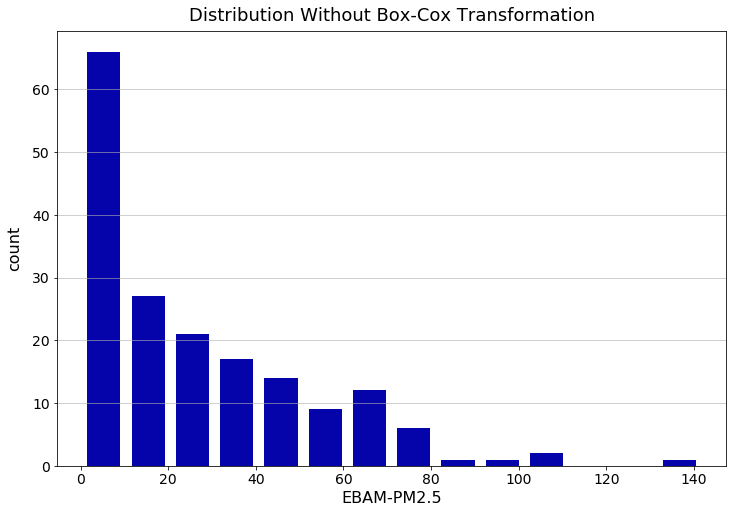

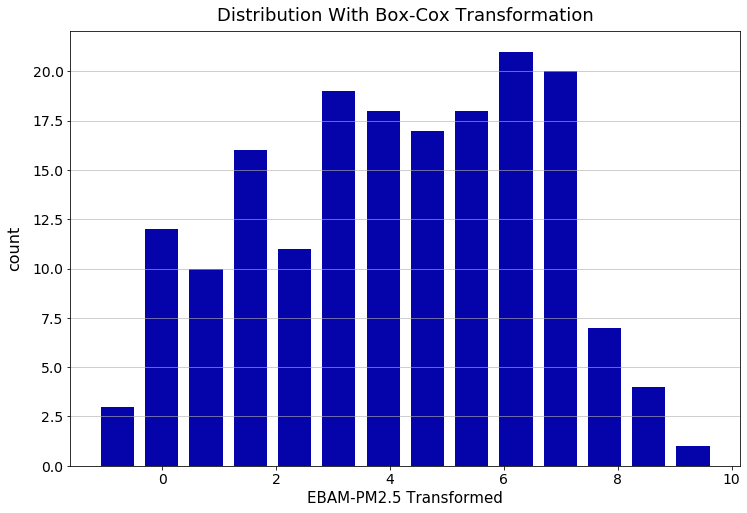

Index(['date', 'year', 'month', 'day', 'pm25', 'pm25_prev_day', 'RELHUMID',
       'RH_day', 'AIRTEMP_F', 'AT_day', 'AT_diff', 'WS_ms', 'MIXDEPTH_m',
       'MD_day', 'MD_diff', 'SUN_FLUX', 'SF_day', 'RAINFALL', 'RF_day',
       'PRESSURE', 'clouds_20', 'rain_2hrs', 'yak_pm25', 'OMC', 'no_fires',
       'note', 'trans_pm25'],
      dtype='object')


In [410]:
# ##Apply BoxCox Transformation to pm2.5  
# #https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution

# df = df[(df['pm25']>1)]
df['trans_pm25'], lmbda = stats.boxcox(df['pm25'])
print('Best lambda parameter = %s' % round(lmbda, 3))

#Non-Transformed
plt.figure(figsize=(12,8))
plt.hist(df['pm25'], bins=14,color='#0504aa',alpha=1, rwidth=.75)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('EBAM-PM2.5',fontsize=16)
# plt.xticks(np.arange(min(df['pm25'])-1, max(df['pm25'])+1, 10), size=12)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('count',fontsize=16, labelpad=10)
plt.title('Distribution Without Box-Cox Transformation',fontsize=18,pad=10)
plt.show()

#Transformed
plt.figure(figsize=(12,8))
plt.hist(df['trans_pm25'], bins=14,color='#0504aa',alpha=1, rwidth=.75)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('EBAM-PM2.5 Transformed',fontsize=15)
# plt.xticks(np.arange(min(df['trans_pm25']), max(df['trans_pm25']), 1), size=12)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('count',fontsize=16, labelpad=10)
plt.title('Distribution With Box-Cox Transformation',fontsize=18, pad=10)
plt.show()

print(df.columns)

In [423]:
# df_x = df[[
# #             'RELHUMID',
#             'RH_day',
#            'AIRTEMP',
# #            'TEMP_high',
# #            'WS',
# #             'MIXDEPTH',
# #             'MD_day',
#             'MD_diff',
# #             'month',
# #            'day',
# #            'pm25_prev_day',
# #            'VentilationIndex',
# #            'RAINFALL',
# #            'SF_day',
# #            'TEMP_diff',
# #            'pm25_afternoon',
# #            'OMC',
#            'clouds_20',
#            'rain_2hrs'
# ]]

df_x = df[[
            'RELHUMID',
#             'RH_day',
           'AIRTEMP_F',
#            'AT_day',
#             'AT_diff',
           'WS_ms',
#             'MIXDEPTH_m',
#             'MD_day',
            'MD_diff',
#             'SUN_FLUX',
#             'SF_day',
#             'RAINFALL',
#             'RF_day',
#             'PRESSURE',
            'clouds_20',
#             'rain_2hrs',
            'pm25_prev_day'
]]

df_y = df[['pm25']]


X = df_x
X = sm.add_constant(X)
y = df_y

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm25   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     29.28
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           6.25e-24
Time:                        15:02:11   Log-Likelihood:                -764.18
No. Observations:                 177   AIC:                             1542.
Df Residuals:                     170   BIC:                             1565.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6767     19.502      0.650      0.517     -25.821      51.175
RELHUMID         -0.3428      0.100     -3.438      0.001      -0.540      -0.146
AIRTEMP_F         0.6197      0.274      2.264      0.025       0.079       1.160
WS_ms            -1.9244      1.798     -1.070      0.286      -5.474       1.626
MD_diff           0.0130      0.005      2.715      0.007       0.004       0.023
clouds_20        -5.4938      3.843     -1.430      0.155     -13.080       2.092
pm25_prev_day     0.1764      0.064      2.763      0.006       0.050       0.302
==============================================================================
Omnibus:                       29.199   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.751
Skew:                           0.920   Prob(JB):                     5.21e-10
Kurtosis:                       4.553   Cond. No.                     1.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

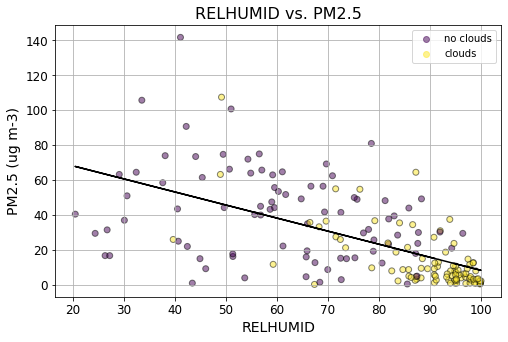

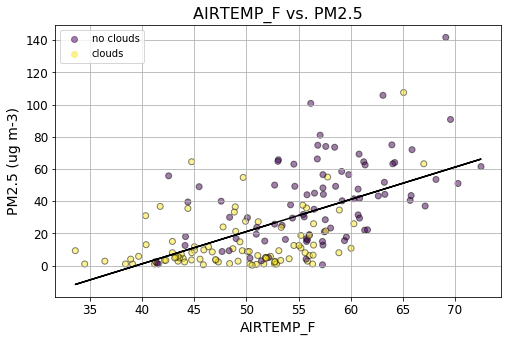

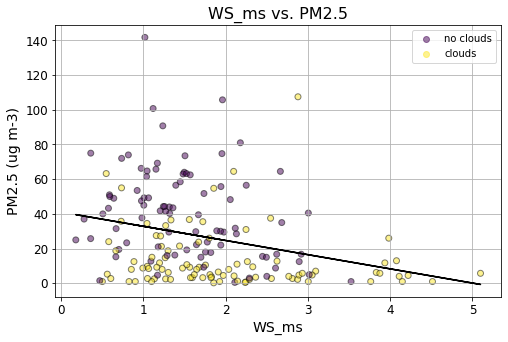

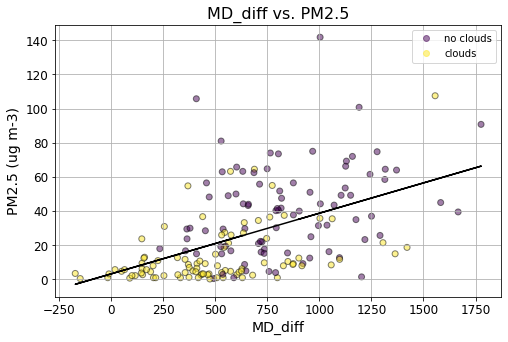

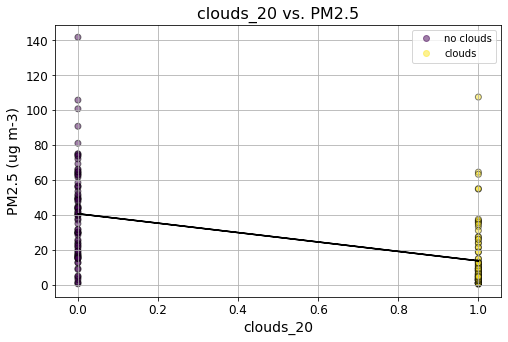

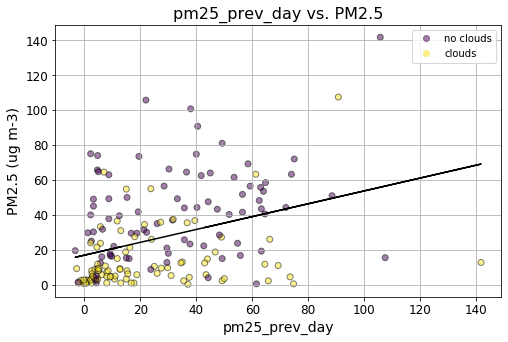

,RELHUMID,AIRTEMP_F,WS_ms,MD_diff,clouds_20,pm25_prev_day
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,75.301770,52.824627,1.741583,662.698343,0.514124,26.814595
std,20.973521,7.638956,0.928475,369.688268,0.501218,25.768783
min,20.450000,33.575000,0.179309,-173.025000,0.000000,-3.250000
25%,59.525000,47.300000,1.100337,412.100000,0.000000,5.000000
50%,81.866667,53.105000,1.570113,630.025000,1.000000,18.000000
75%,93.875000,57.470000,2.179205,874.875000,1.000000,43.000000
max,100.000000,72.500000,5.097864,1776.650000,1.000000,141.750000


In [424]:
#Make a plot between each x variable and y
import matplotlib.pyplot as plt
%matplotlib inline

# sns.reset_orig() #Doesn't let seaborn override matplotlib

for i in df_x.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. PM2.5".format(i),fontsize=16)
    scatter = plt.scatter(x=df_x[i],y=df_y,
                          c=df['clouds_20'],alpha=0.5, edgecolor='k') ##,edgecolor='k' 
    plt.grid(True)
    plt.xlabel(i,fontsize=14)
    plt.ylabel('PM2.5 (ug m-3)',fontsize=14)
    classes = ['no clouds','clouds']
    plt.xticks(size=12)
    plt.yticks(size=12)
#     classes = ['7','8','9','10']
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
#   Line of best fit
    m, b = np.polyfit(x=df_x[i],y=df_y,deg=1)
    plt.plot(df_x[i], m*df_x[i] + b,c='black')
    plt.show()
df_x.describe()

In [ ]:
####################################### Pair Plot ############################################
################ https://python-graph-gallery.com/111-custom-correlogram/ ####################

import matplotlib.pyplot as plt
import seaborn as sns

df_all = df[[
            'RELHUMID',
#             'RH_day',
           'AIRTEMP_F',
#            'AT_day',
#             'AT_diff',
           'WS_ms',
#             'MIXDEPTH_m',
#             'MD_day',
            'MD_diff',
#             'SUN_FLUX',
            'SF_day',
#             'RAINFALL',
#             'RF_day',
#             'PRESSURE',
#             'clouds_20',
#             'rain_2hrs',
            'pm25_prev_day',
            'trans_pm25'
]]

 # with regression
sns.pairplot(df_all, kind="reg")
plt.show()
 
# without regression
sns.pairplot(df_all, kind="scatter")
plot.show()

In [335]:
# from statsmodels.tools.eval_measures import rmse
# # fit your model which you have already done
# # now generate predictions
# # ypred = model.predict(X)

# # calc rmse
# rmse = rmse(y, predictions)
# print(rmse)


from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, predictions)))


Mean Absolute Error: 13.917192592858607
Mean Squared Error: 342.72106482148206
Root Mean Squared Error: 18.51272710384621


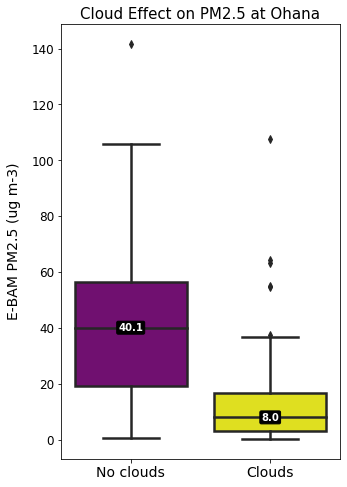

In [425]:
cloud = df['clouds_20'].map({0: 'No clouds', 1: 'Clouds'})
plt.figure(figsize=(5,8))
my_pal = {"No clouds": "purple", "Clouds": "yellow"}
ax = sns.boxplot(x=cloud, y=df["pm25"],order=['No clouds','Clouds'], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=14) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=12) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('PA PM2.5 (ug m-3)',fontsize=14)
plt.title('Cloud Effect on PM2.5 at Ohana', size=15, pad=5)
plt.xlabel('')
plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=14, labelpad=10)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

# ax.figure.tight_layout()

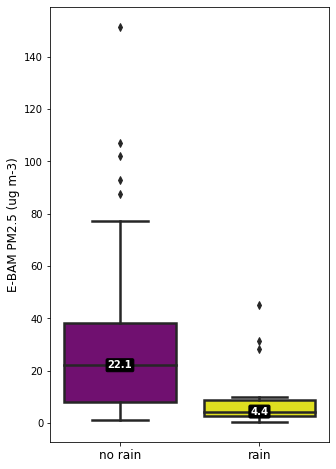

In [142]:
cloud = df['rain_2hrs'].map({0: 'no rain', 1: 'rain'})
plt.figure(figsize=(5,8))
my_pal = {"no rain": "purple", "rain": "yellow"}
ax = sns.boxplot(x=cloud, y=df["pm25"], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=12) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=10) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=12)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

# ax.figure.tight_layout()

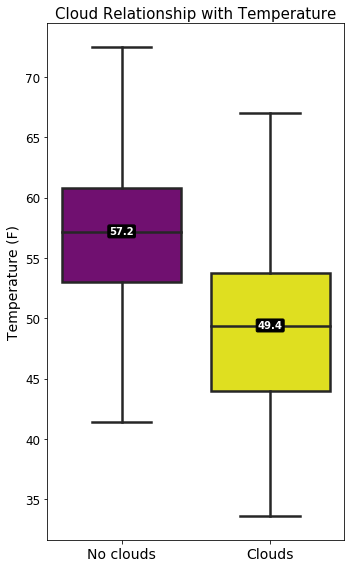

In [427]:
cloud = df['clouds_20'].map({0: 'No clouds', 1: 'Clouds'})
plt.figure(figsize=(5,8))
my_pal = {"No clouds": "purple", "Clouds": "yellow"}
ax = sns.boxplot(x=cloud, y=df["AIRTEMP_F"],order=['No clouds','Clouds'], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=14) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=12) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('Temperature (F)',fontsize=14)
plt.title('Cloud Relationship with Temperature', size=15, pad=5)
plt.xlabel('')
# plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=14, labelpad=10)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

ax.figure.tight_layout()

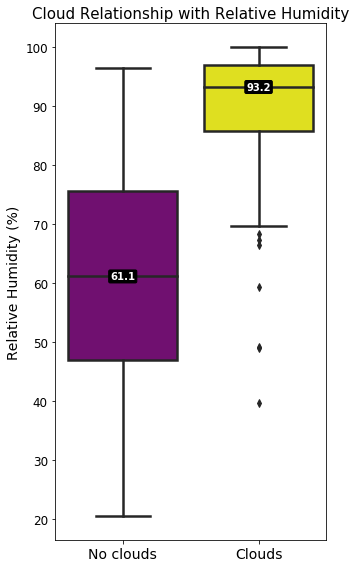

In [432]:
cloud = df['clouds_20'].map({0: 'No clouds', 1: 'Clouds'})
plt.figure(figsize=(5,8))
my_pal = {"No clouds": "purple", "Clouds": "yellow"}
ax = sns.boxplot(x=cloud, y=df["RELHUMID"],order=['No clouds','Clouds'], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=14) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=12) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('Relative Humidity (%)',fontsize=14)
plt.title('Cloud Relationship with Relative Humidity', size=15, pad=5)
plt.xlabel('')
# plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=14, labelpad=10)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

ax.figure.tight_layout()

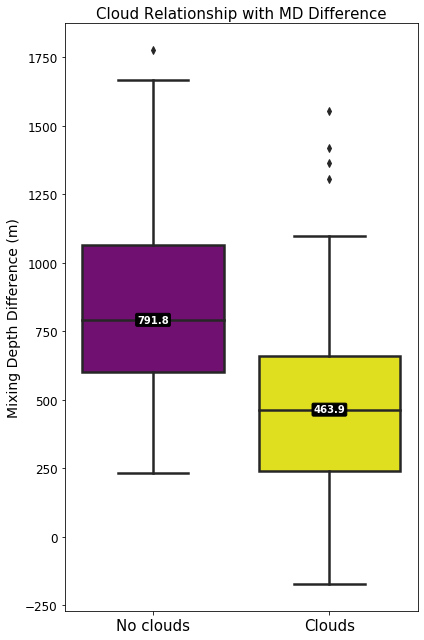

In [443]:
cloud = df['clouds_20'].map({0: 'No clouds', 1: 'Clouds'})
plt.figure(figsize=(6,9))
my_pal = {"No clouds": "purple", "Clouds": "yellow"}
ax = sns.boxplot(x=cloud, y=df["MD_diff"],order=['No clouds','Clouds'], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=15) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=12) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('Mixing Depth Difference (m)',fontsize=14)
plt.title('Cloud Relationship with MD Difference', size=15, pad=5)
plt.xlabel('')
# plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=14, labelpad=10)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

ax.figure.tight_layout()

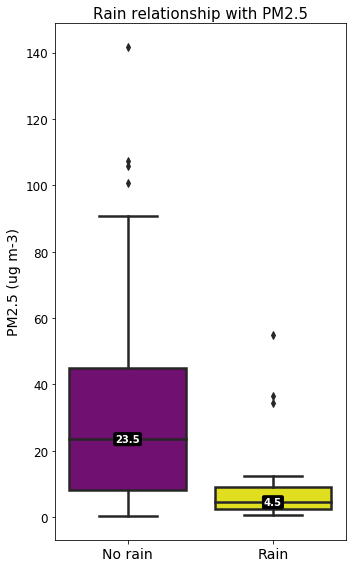

In [435]:
cloud = df['rain_2hrs'].map({0: 'No rain', 1: 'Rain'})
plt.figure(figsize=(5,8))
my_pal = {"No rain": "purple", "Rain": "yellow"}
ax = sns.boxplot(x=cloud, y=df["pm25"],order=['No rain','Rain'], linewidth=2.5, palette=my_pal)
ax.tick_params(axis='x', which='major', labelsize=14) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=12) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('PM2.5 (ug m-3)',fontsize=14)
plt.title('Rain relationship with PM2.5', size=15, pad=5)
plt.xlabel('')
# plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=14, labelpad=10)

#Display median onto each box plot
v = ax.axes
lines = v.get_lines()
categories = v.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    v.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(boxstyle='round',facecolor='black',edgecolor='black', pad=0.15))

ax.figure.tight_layout()

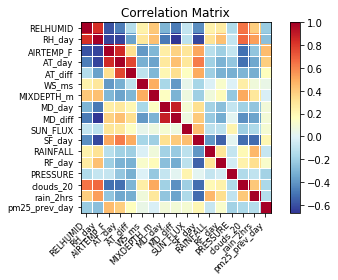

In [143]:
# Plot correlation and heatmap (multicollinearity)
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.correlation import plot_corr
from statsmodels.stats.outliers_influence import variance_inflation_factor


corr = df_x.corr()
fig = plot_corr(corr,xnames=corr.columns)

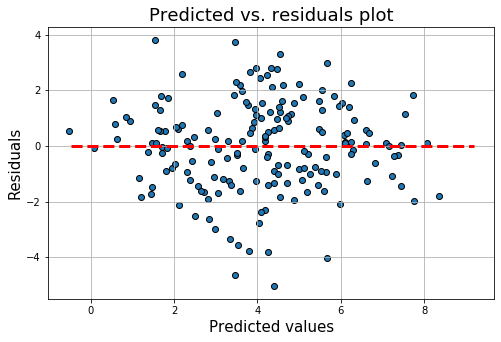

In [279]:
import matplotlib.pyplot as plt
#Model vs Residuals (homoscedasticity)


plt.figure(figsize=(8,5))
p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Predicted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Predicted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

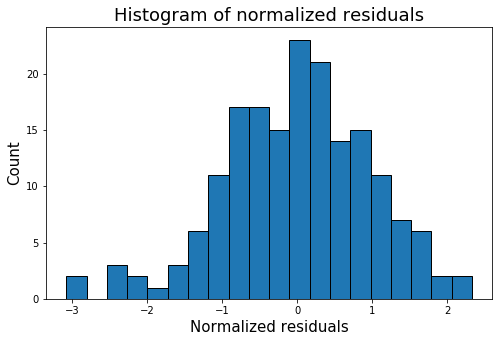

In [280]:
#Historgram of normalized residuals
plt.figure(figsize=(8,5))
plt.hist(model.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

<Figure size 576x360 with 0 Axes>

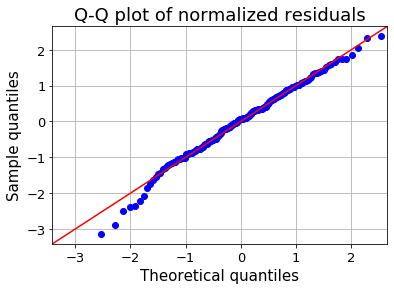

In [281]:
#QQ plot for normality
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

C:\Users\sph0088\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


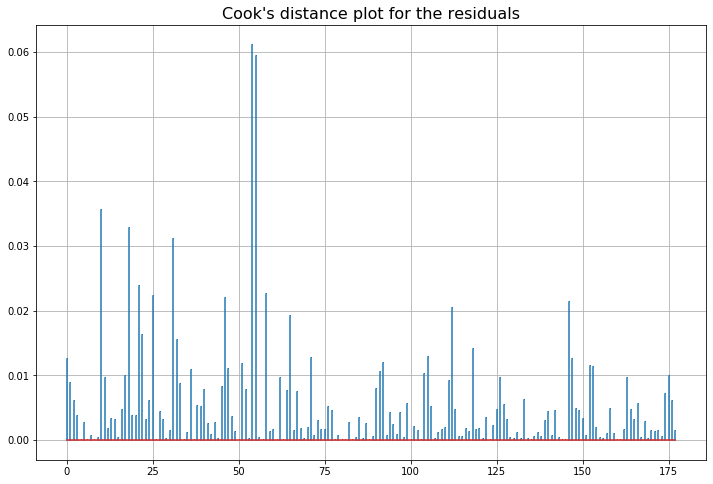

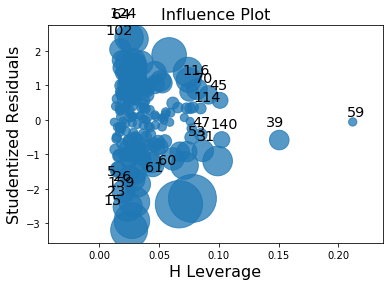

<Figure size 1440x864 with 0 Axes>

In [282]:
#Cook's distance (checking for outliers in residuals)
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(model)
(c, p) = inf.cooks_distance
plt.figure(figsize=(12,8))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

#Leverage Influence Plot
sm.graphics.influence_plot(model)
plt.figure(figsize=(20,12))
plt.show()

Text(0, 0.5, 'E-BAM PM2.5 (ug m-3)')

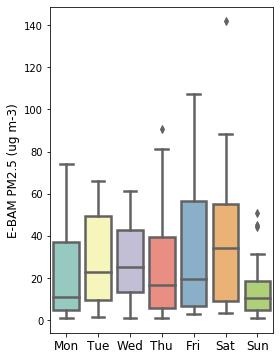

In [111]:
day = df['day'].map({0: 'Mon', 1: 'Tue',2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
plt.figure(figsize=(4,6))
ax = sns.boxplot(x=day, y=df["pm25"], linewidth=2.5, palette="Set3")
ax.tick_params(axis='x', which='major', labelsize=12) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=10) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=12)

Text(0, 0.5, 'E-BAM PM2.5 (ug m-3)')

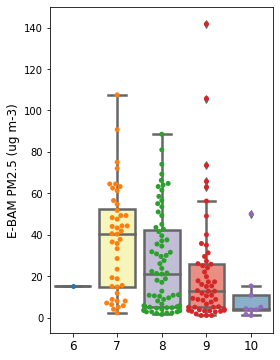

In [117]:
x = df['month']#.map({6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})
y = df["pm25"]
plt.figure(figsize=(4,6))
ax = sns.boxplot(x=x, y=y, linewidth=2.5, palette="Set3")
swarm = sns.swarmplot(x=x, y=y)
ax.tick_params(axis='x', which='major', labelsize=12) #Default selection is major
ax.tick_params(axis='y', which='major', labelsize=10) #axis='both' to change both at once
plt.xlabel('')
plt.ylabel('E-BAM PM2.5 (ug m-3)',fontsize=12)

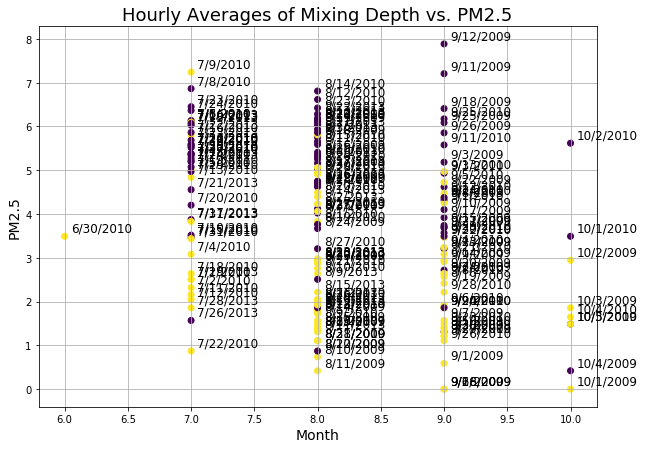

In [108]:
y = df['trans_pm25'].to_numpy()
x = df['month'].to_numpy()
d = df['date'].to_numpy()

plt.figure(figsize=(10,7))
plt.scatter(x,y,c=df['clouds_20'])
for i, txt in enumerate(d):
    plt.annotate(txt, (x[i], y[i]), xytext=(x[i]+0.05,y[i]+0.1),fontsize=12)
plt.title("Hourly Averages of Mixing Depth vs. PM2.5",fontsize=18)
plt.grid(True)
plt.xlabel('Month',fontsize=14)
plt.ylabel('PM2.5',fontsize=14)
plt.show()

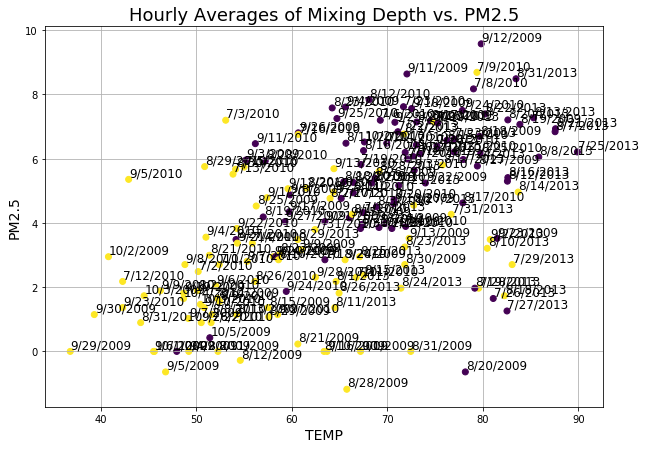

In [253]:
y = df['trans_pm25'].to_numpy()
x = df['AT_day'].to_numpy()
d = df['date'].to_numpy()

plt.figure(figsize=(10,7))
plt.scatter(x,y,c=df['clouds_20'])
for i, txt in enumerate(d):
    plt.annotate(txt, (x[i], y[i]), xytext=(x[i]+0.05,y[i]+0.1),fontsize=12)
plt.title("Hourly Averages of Mixing Depth vs. PM2.5",fontsize=18)
plt.grid(True)
plt.xlabel('TEMP',fontsize=14)
plt.ylabel('PM2.5',fontsize=14)
plt.show()

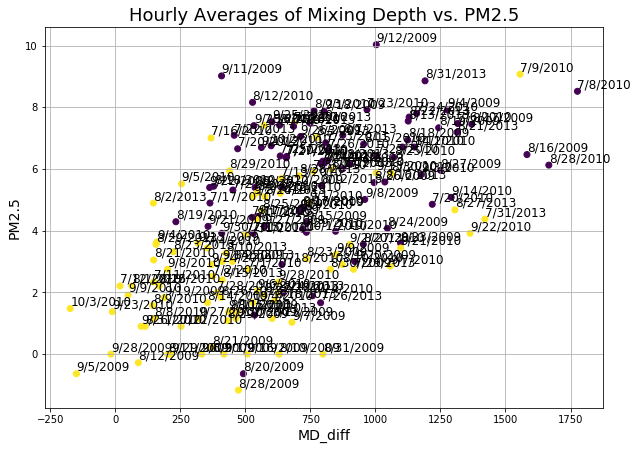

In [233]:
y = df['trans_pm25'].to_numpy()
x = df['MD_diff'].to_numpy()
d = df['date'].to_numpy()

plt.figure(figsize=(10,7))
plt.scatter(x,y,c=df['clouds_20'])
for i, txt in enumerate(d):
    plt.annotate(txt, (x[i], y[i]), xytext=(x[i]+0.05,y[i]+0.1),fontsize=12)
plt.title("Hourly Averages of Mixing Depth vs. PM2.5",fontsize=18)
plt.grid(True)
plt.xlabel('MD_diff',fontsize=14)
plt.ylabel('PM2.5',fontsize=14)
plt.show()